# Notebook for prediction result analysis with figures

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"]=300
from sklearn.metrics import roc_auc_score


In [7]:
data_dir="./results/runs/MLP_split_large_ave_cdhit08"
score_path=os.path.join(data_dir,"score_dict.pkl")
preds_path=os.path.join(data_dir,"test_pred_result.pkl")

with open(score_path,"rb") as f:
    score=pickle.load(f)
with open(preds_path,"rb") as f:
    pred_results=pickle.load(f)

print(score)


{'accuracy': 0.6260190217391305, 'precision': 0.6030871003307607, 'recall': 0.7416949152542373, 'f1': 0.6652477956825782, 'confusion_matrix': array([[ 749,  720],
       [ 381, 1094]]), 'fpr_all': array([0.        , 0.        , 0.        , ..., 0.99863853, 0.99931926,
       1.        ]), 'tpr_all': array([0.00000000e+00, 6.77966102e-04, 1.35593220e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), 'roc_thresh': array([1.8853061 , 0.88530606, 0.8842882 , ..., 0.02403904, 0.02226879,
       0.01997573], dtype=float32), 'auc_roc': 0.6774672035628988}


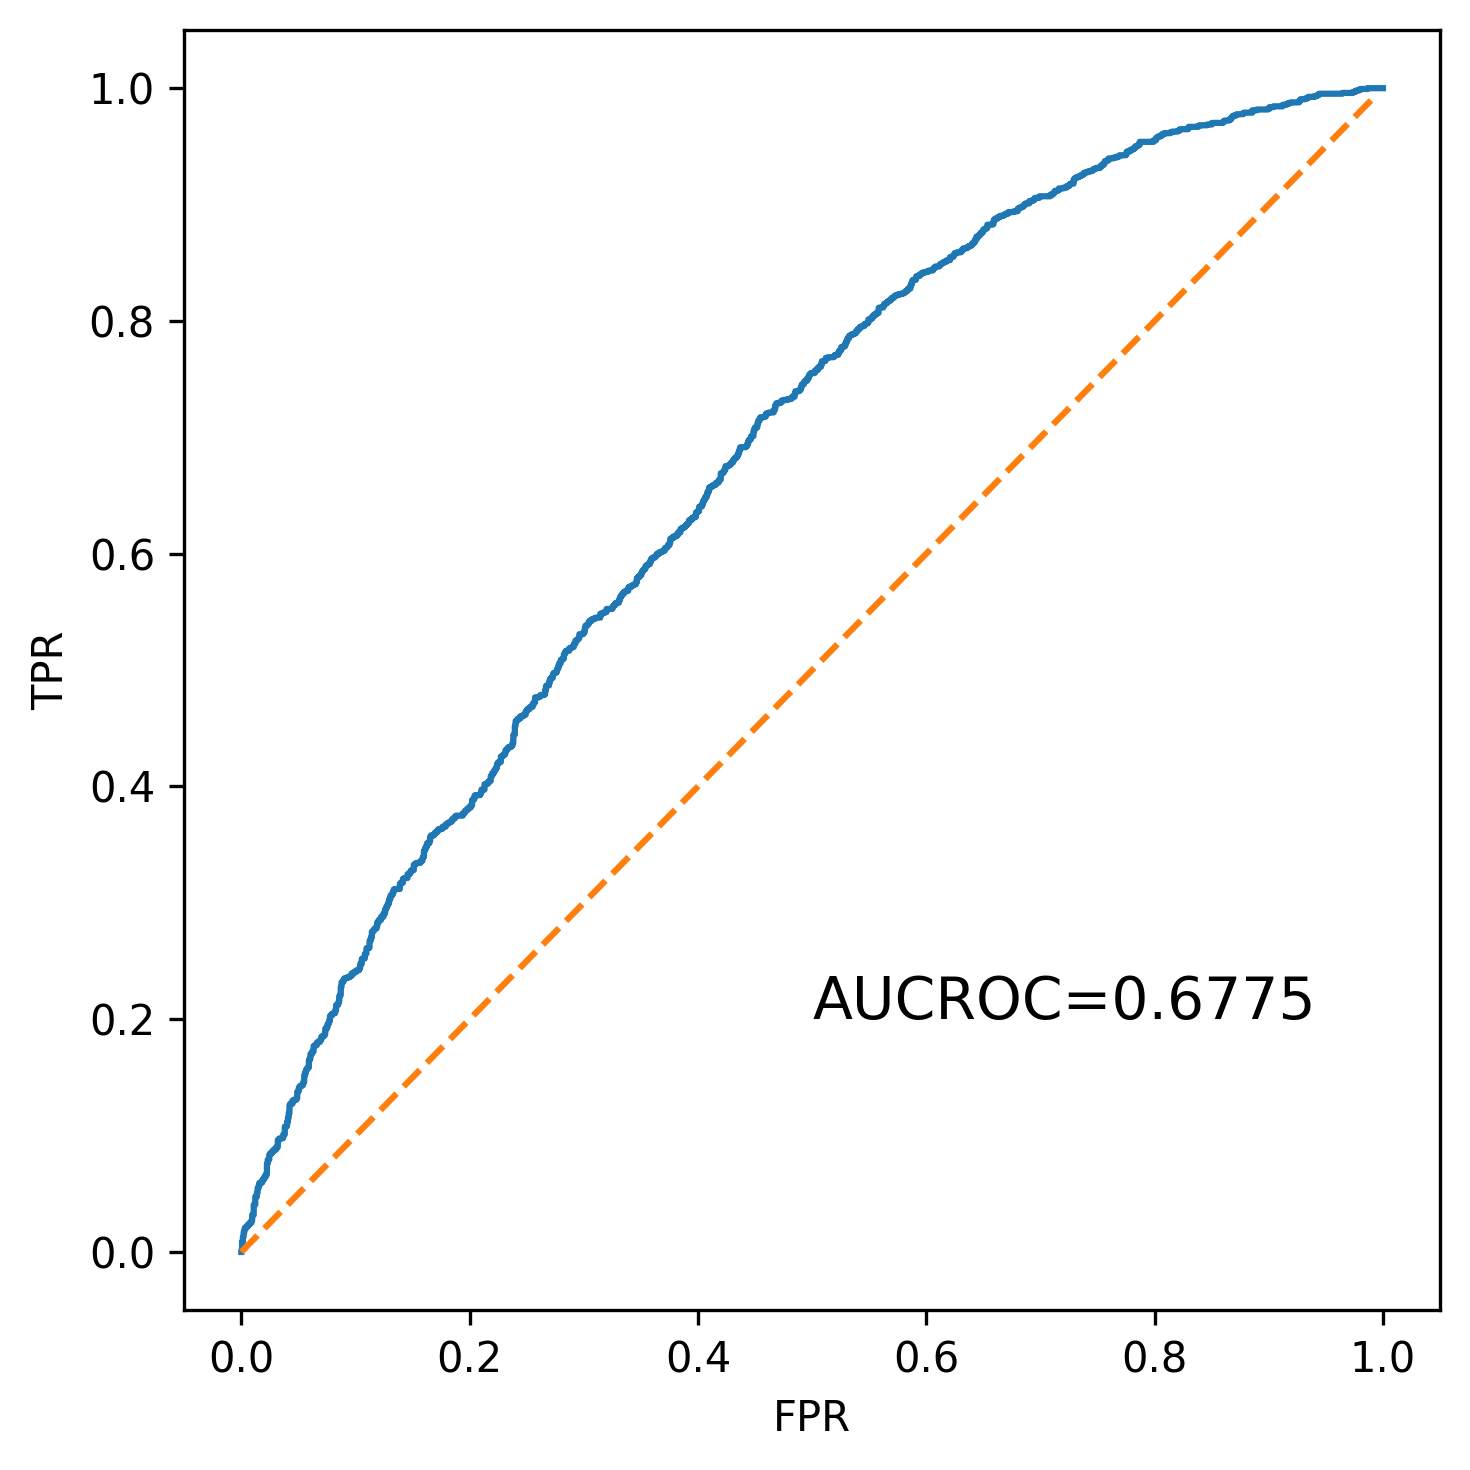

In [3]:
fig=plt.figure(figsize=(5,5))
line=np.arange(0,1,0.01)
auc_roc=roc_auc_score(pred_results[1],pred_results[2])
plt.plot(score["fpr_all"],score["tpr_all"])
plt.plot(line,line,linestyle="--")
plt.text(0.5,0.2,f"AUCROC={auc_roc:.4f}",fontsize=14)
#plt.title(os.path.basename(data_dir))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.tight_layout()
plt.savefig(f"./results/imgs/aucroc_{os.path.basename(data_dir)}")


## Multi result comparison

In [4]:
## Data setup
root_dir="./results/runs"
data_list=["MLP_split_large_ave_cdhit08","MLP_split_large_ave_cdhit09"]
score_dic=dict()
pred_res_dic=dict()
for d in data_list:
    data_dir=os.path.join(root_dir,d)
    score_path=os.path.join(data_dir,"score_dict.pkl")
    preds_path=os.path.join(data_dir,"test_pred_result.pkl")

    with open(score_path,"rb") as f:
        score=pickle.load(f)
    with open(preds_path,"rb") as f:
        pred_results=pickle.load(f)
    
    score_dic[d]=score
    pred_res_dic[d]=pred_results


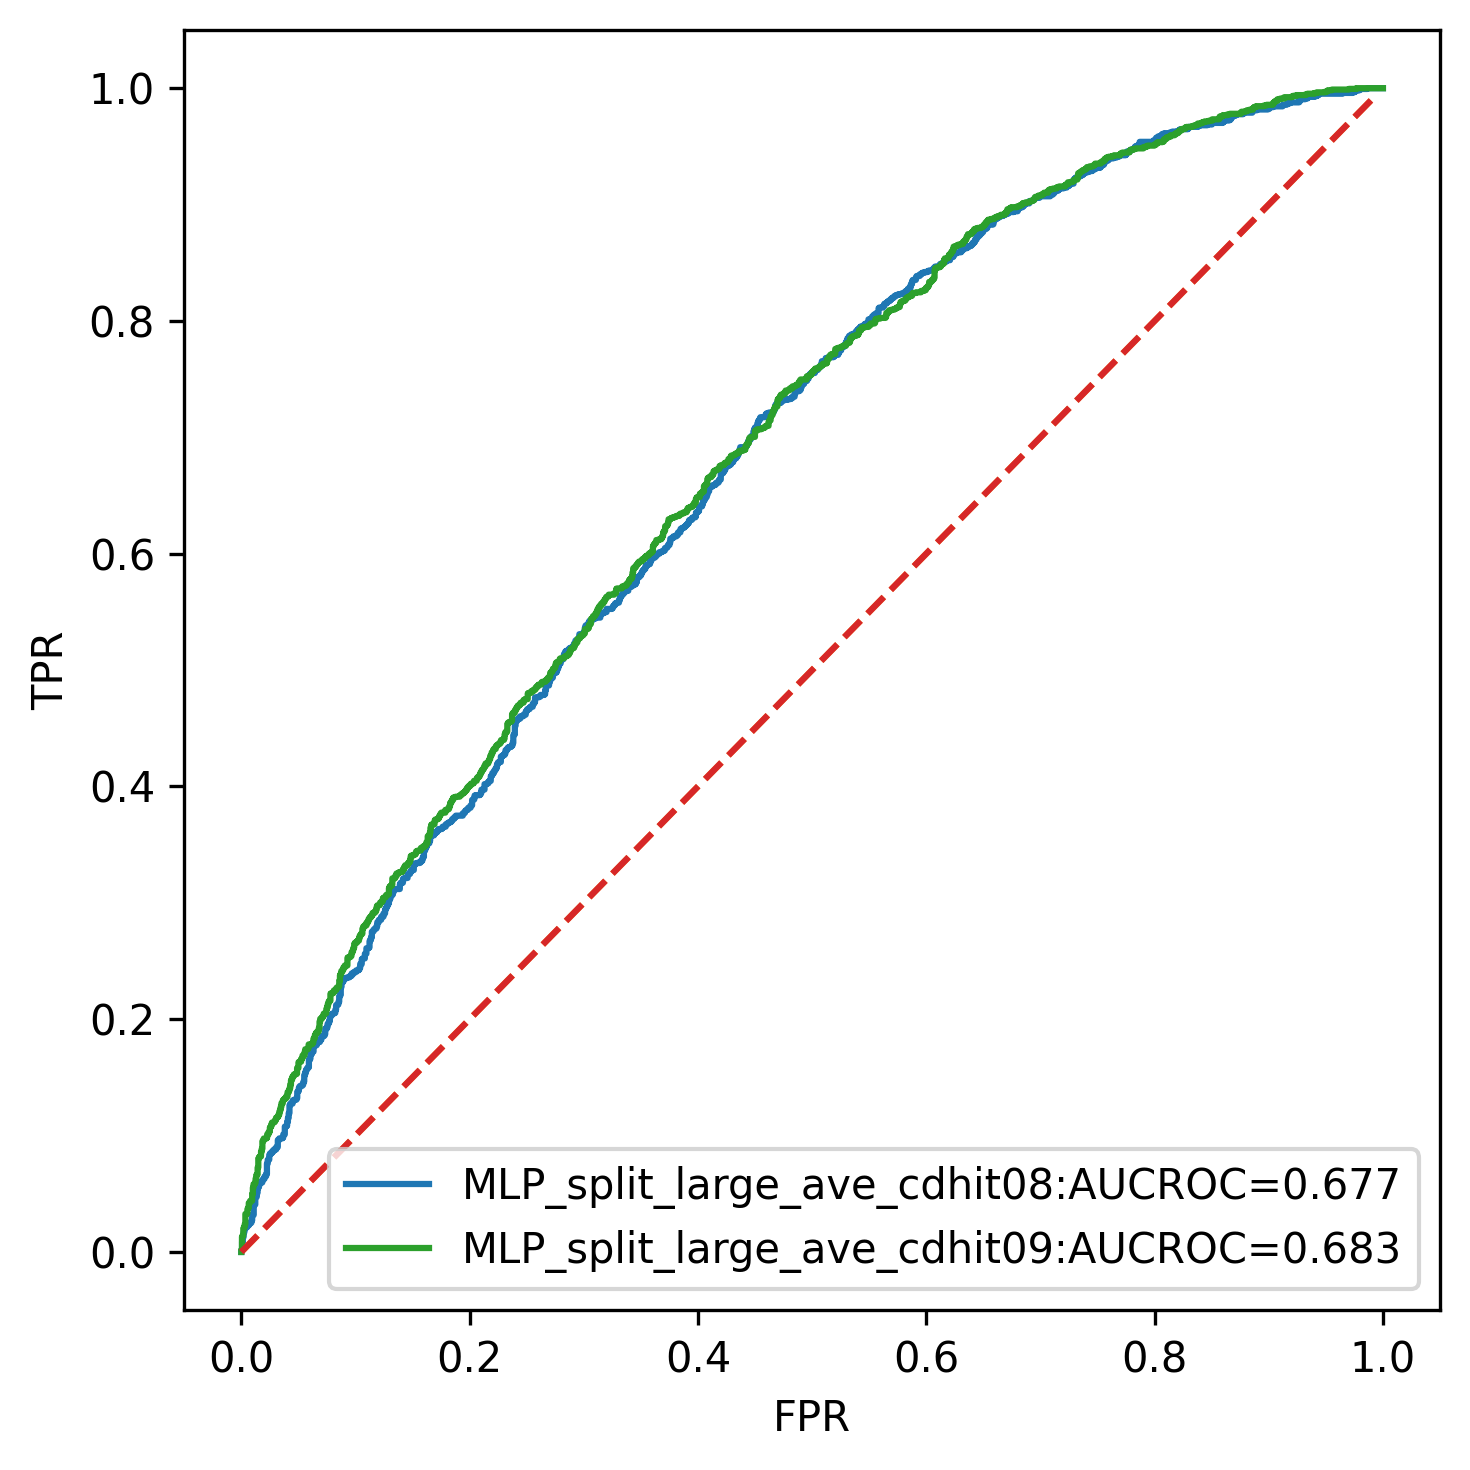

In [6]:
fig=plt.figure(figsize=(5,5))
line=np.arange(0,1,0.01)
for (s_k,s_v),(p_k,p_v)in zip(score_dic.items(),pred_res_dic.items()):
    auc_roc=roc_auc_score(p_v[1],p_v[2])
    plt.plot(s_v["fpr_all"],s_v["tpr_all"],label=f"{s_k}:AUCROC={auc_roc:.3f}")
    plt.plot(line,line,linestyle="--")
    #plt.text(0.5,0.2,f"AUCROC={auc_roc:.4f}",fontsize=14)
    #plt.title(os.path.basename(data_dir))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.tight_layout()
    plt.savefig(f"./results/imgs/aucroc_human_cdhit_id_comparison")
